In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import corner
import astropy.units as u

from astropy.coordinates import SkyCoord
from astropy.time import Time
from astroplan import Observer, FixedTarget, time_grid_from_range
from astroplan.plots import plot_airmass

from astropy.table import Table

from ztfquery import fields



>>> from astroplan import download_IERS_A
>>> download_IERS_A()
 [astroplan.utils]


In [3]:
#get the colours for the colour map
hsv = plt.get_cmap('hsv')
#define the time steps for each Wednesday since the 17th of the October
times = time_grid_from_range(Time(["2020-01-01 00:00", "2020-04-15 00:00"]), time_resolution=7*u.day)

#load the data for the field ID
fid, ra, dec  = np.loadtxt('March_2hr0.83_fracTime_withCoords.txt', unpack=True)

#fields between 60 and 180 degrees
target_table = Table.read('fields.txt', format='ascii')
tar_tab = target_table[['%ID', 'RA', 'Dec']]
cond = (tar_tab['RA'] > 90) & (tar_tab['RA'] < 270) & (tar_tab['%ID'] < 879)
fid = tar_tab['%ID'][cond]
ra = tar_tab['RA'][cond]
dec = tar_tab['Dec'][cond]
print(len(fid))
#define a colour for each field
colors = hsv(np.linspace(0, 1.0, len(fid)))


436


In [ ]:
#define the observatory
Palomar = Observer.at_site("Palomar")
Paranal = Observer.at_site("Paranal")
#take the first Wednesday as an example
time = times[0]
delta_time = np.linspace(-2, 10, 100)*u.hour
#split the fields into two segments
for i, time in enumerate(times):
    fig = plt.figure(1)
    #make an array as an input to the airmass plotter
    time_array = time+delta_time

    for i, keyval in enumerate(ra[:22]):
        #print(keyval, dec[i])
        coords = SkyCoord(ra=keyval*u.deg, dec=dec[i]*u.deg)
        Ftarg = FixedTarget(name=str(fid[i]), coord=coords)
        plot_airmass(Ftarg, Palomar, time_array, style_kwargs={'color':colors[i]})

    plt.legend(loc=0,prop={'size':6})
    plt.savefig('Plots_Airmass/Airmass_ZUDSfieldsA_'+str(time.datetime.year)+'_'+str(time.datetime.month)+'_'+str(time.datetime.day)+'.pdf', bbox_inches='tight')

    plt.cla()
    fig2 = plt.figure(2)
    for i, keyval in enumerate(ra[22:]):
        print(keyval, dec[i+22], fid[i+22])
        coords = SkyCoord(ra=keyval*u.deg, dec=dec[i+22]*u.deg)
        Ftarg = FixedTarget(name=str(fid[i+22]), coord=coords)
        plot_airmass(Ftarg, Palomar, time_array, style_kwargs={'color':colors[i]})

    plt.legend(loc=0,prop={'size':6})
    plt.savefig('Plots_Airmass/Airmass_ZUDSfieldsB_'+str(time.datetime.year)+'_'+str(time.datetime.month)+'_'+str(time.datetime.day)+'.pdf', bbox_inches='tight')

    plt.cla()
plt.show()


In [ ]:
#write out the file for the number of iband exposures into a dictionary
iband_numexp = np.loadtxt('iband_Nobs_fromDanny.txt')
odict_iband = {}
for i in iband_numexp:
    odict_iband[str(int(i[0]))] = i[1]
print(odict_iband)
print(fid.dtype)

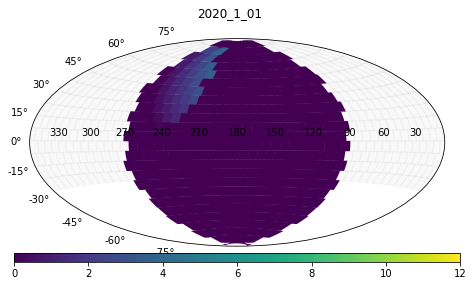

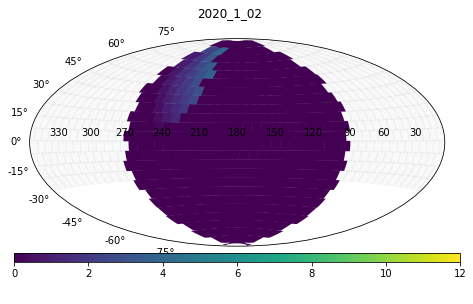

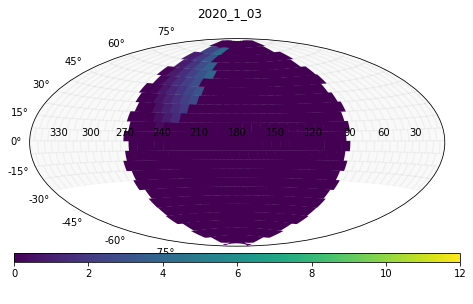

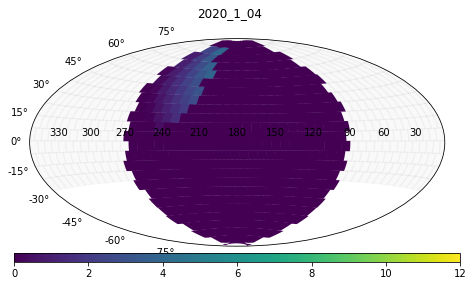

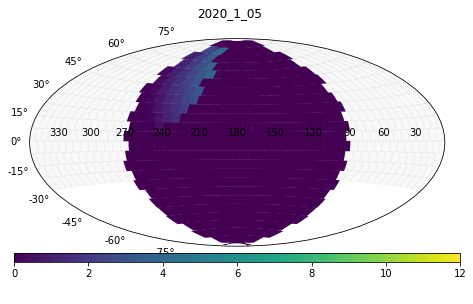

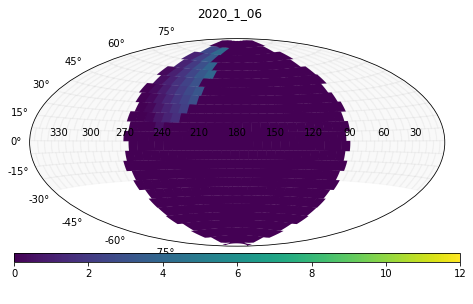

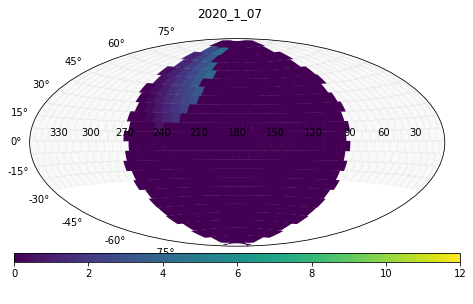

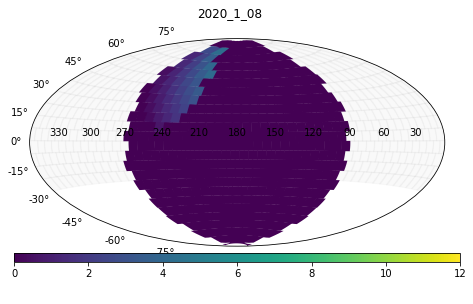

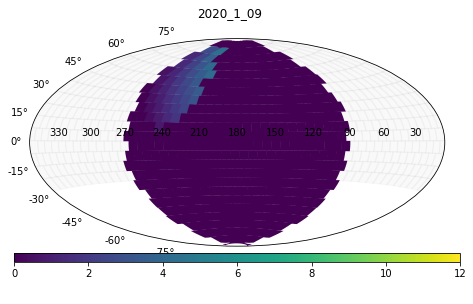

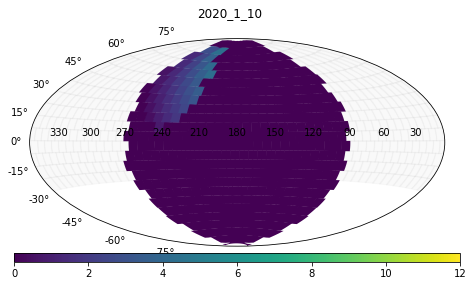

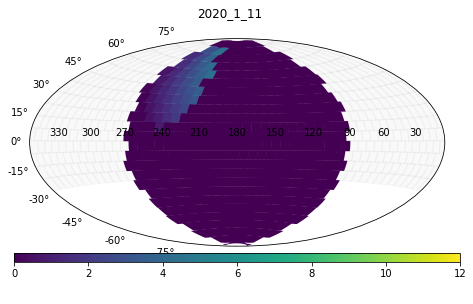

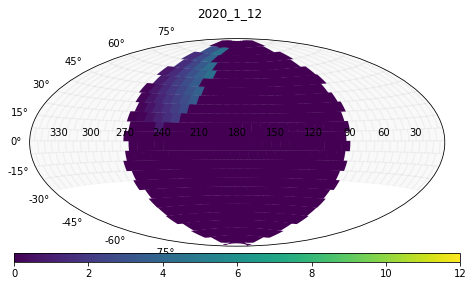

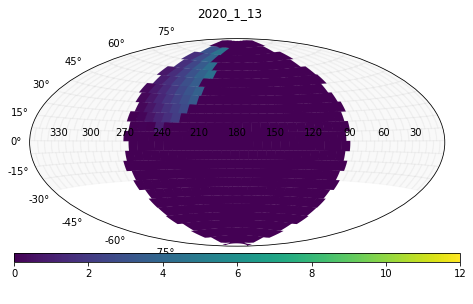

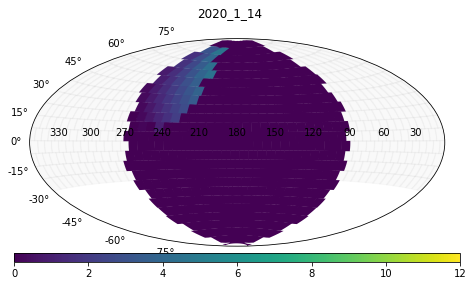

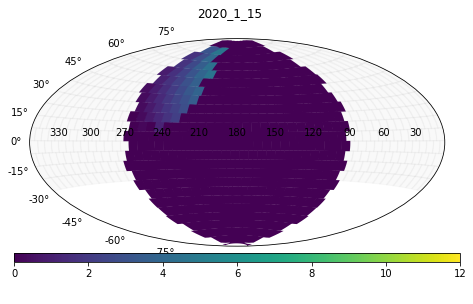

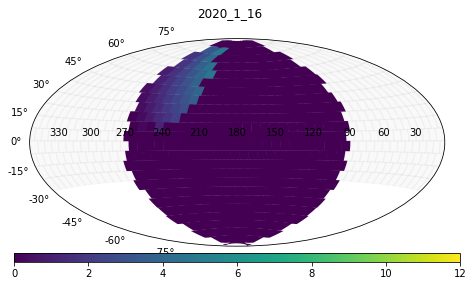

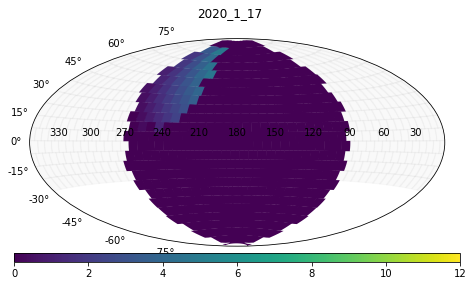

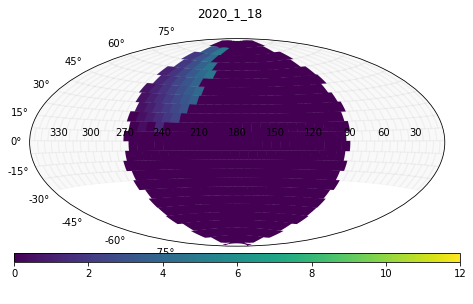

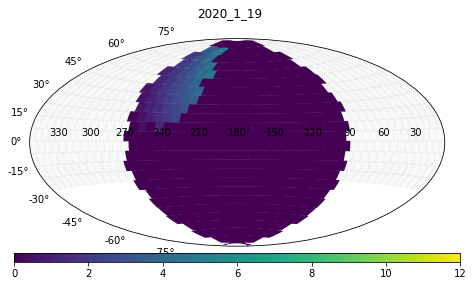

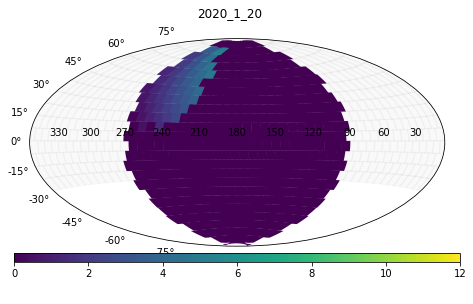

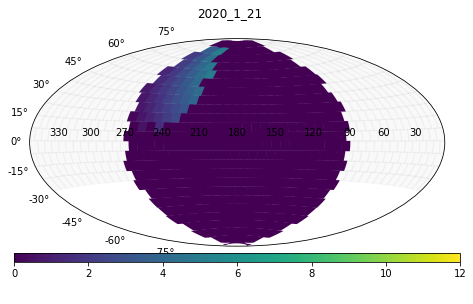

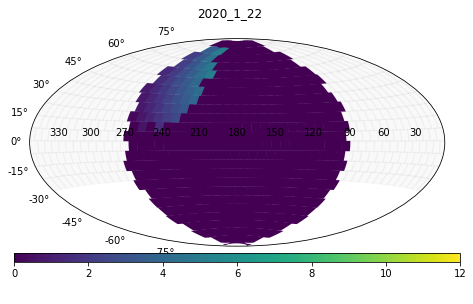

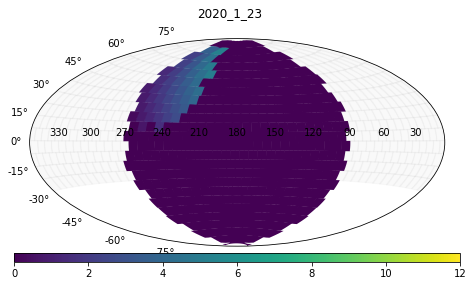

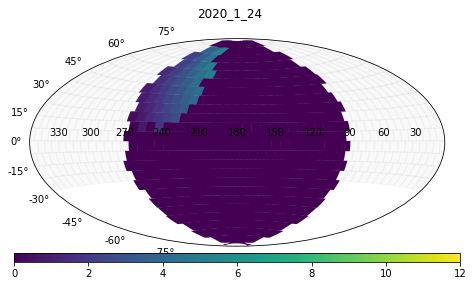

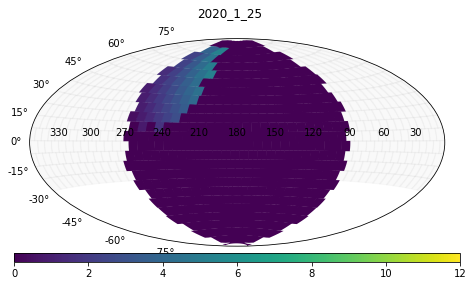

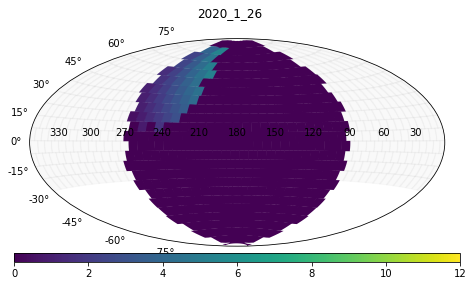

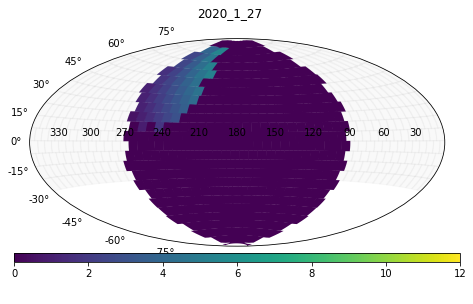

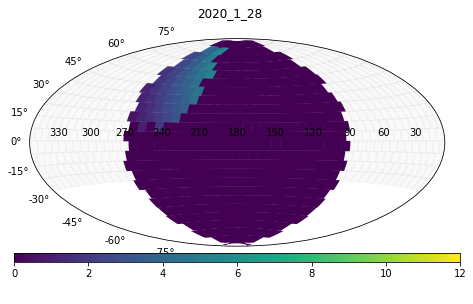

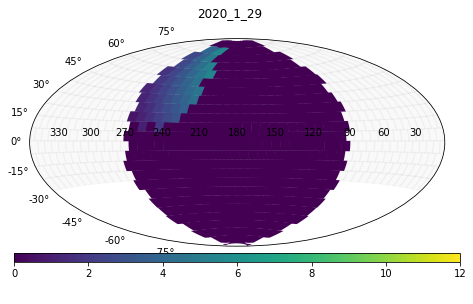

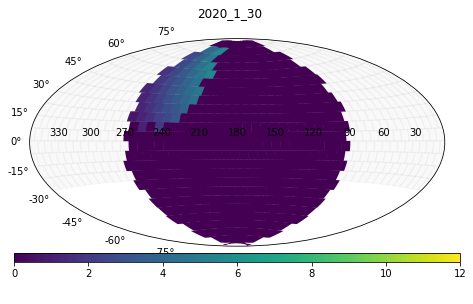

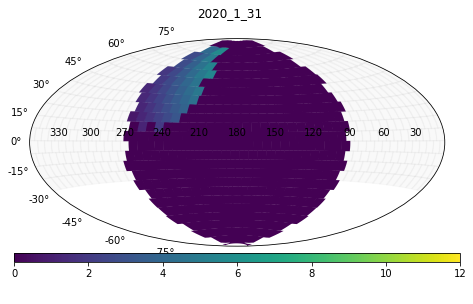

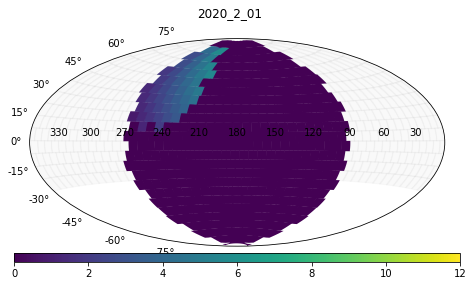

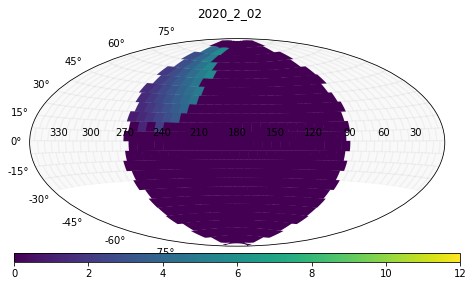

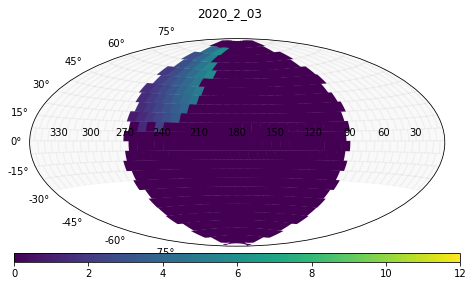

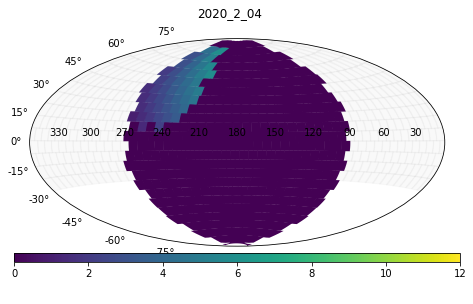

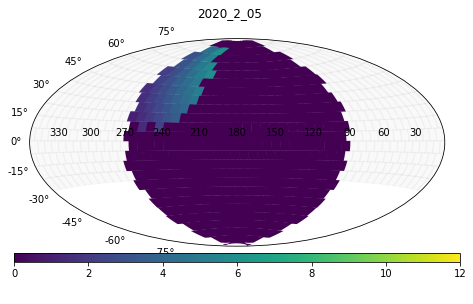

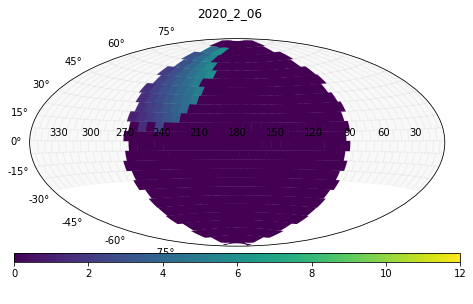

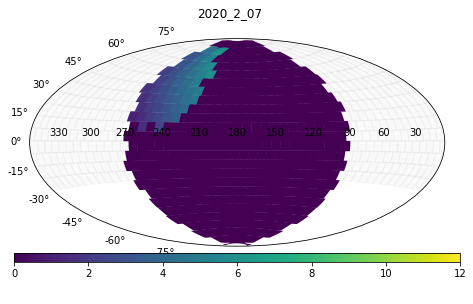

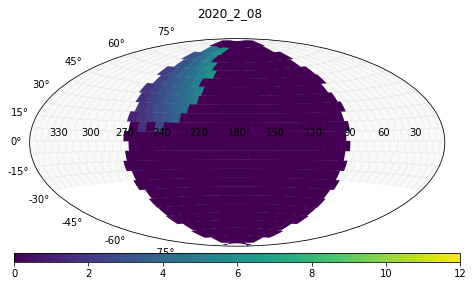

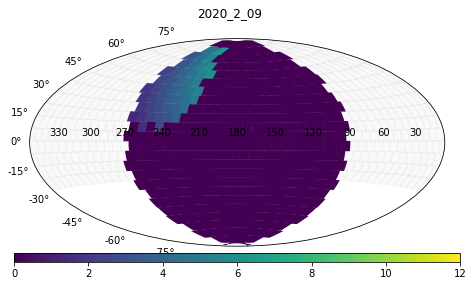

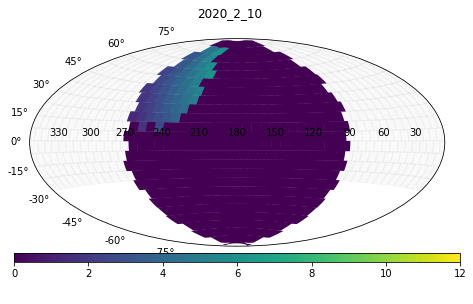

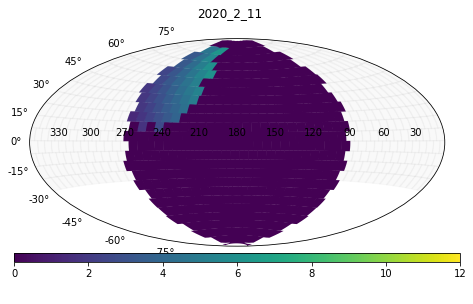

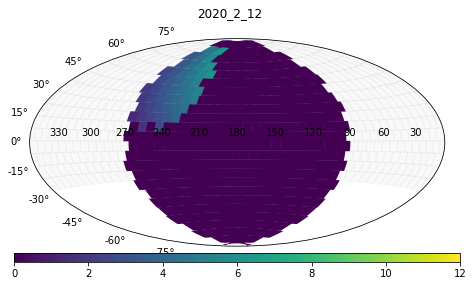

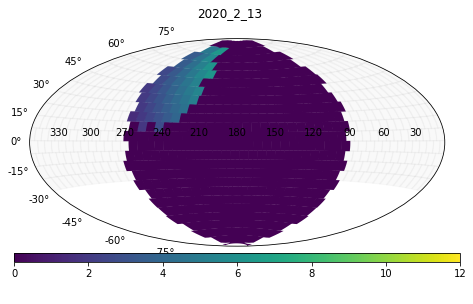

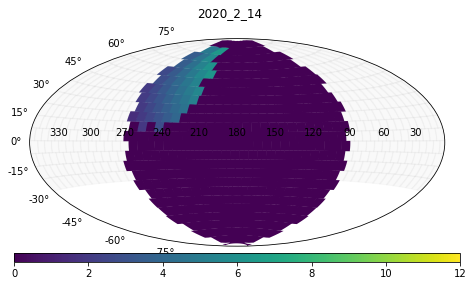

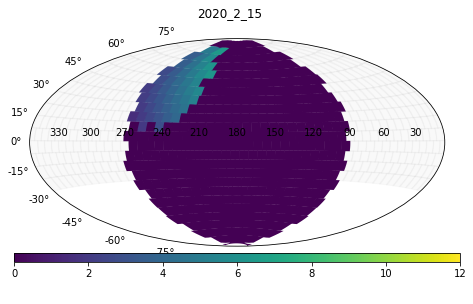

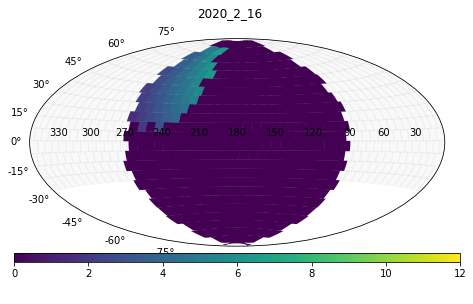

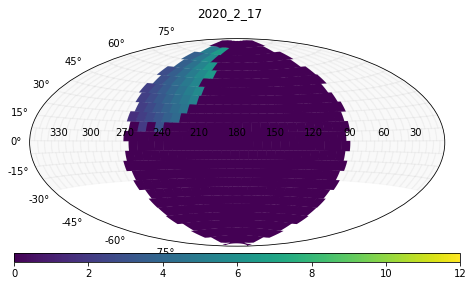

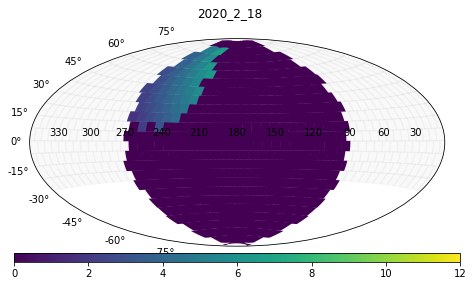

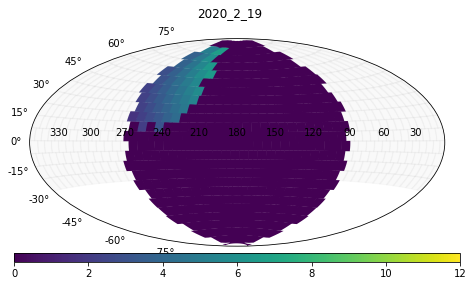

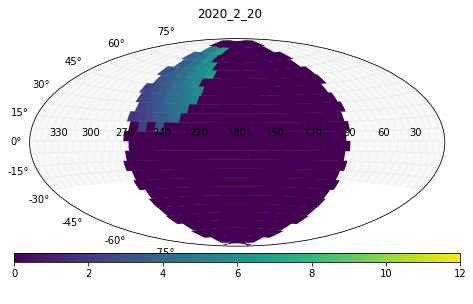

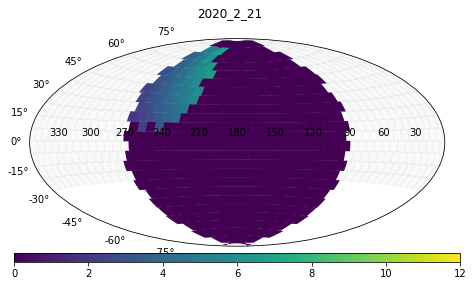

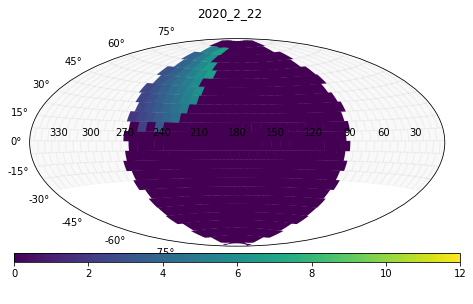

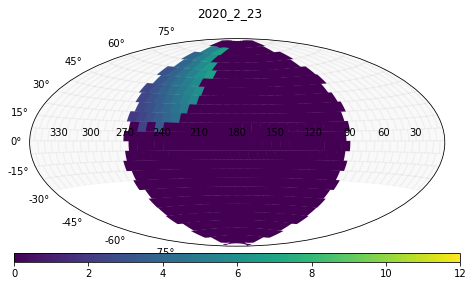

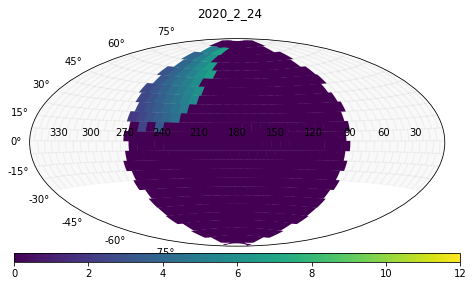

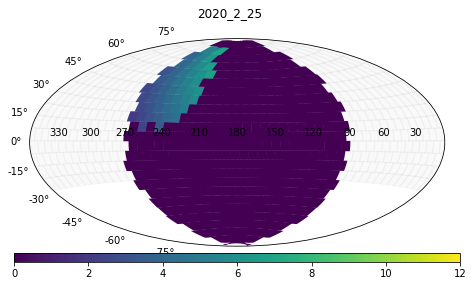

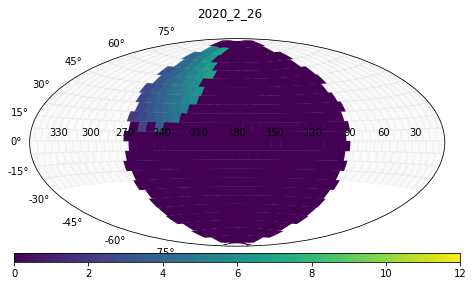

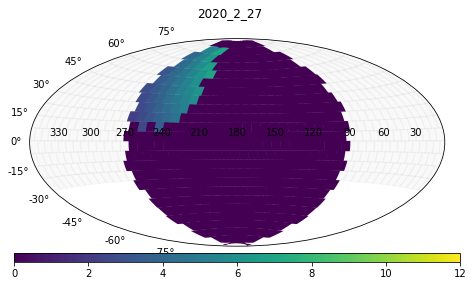

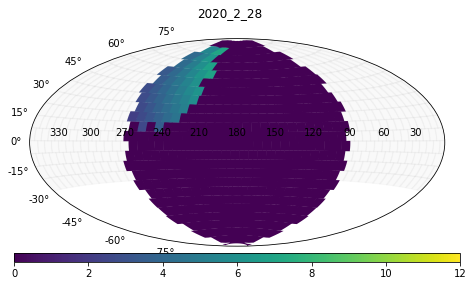

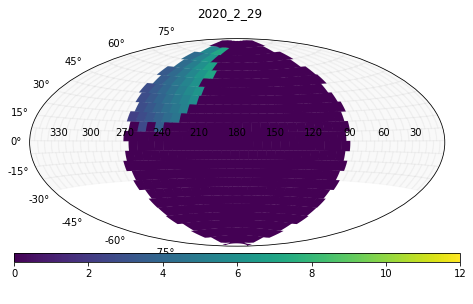

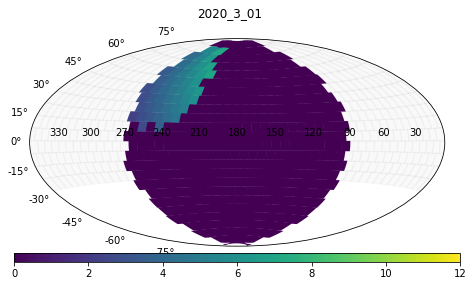

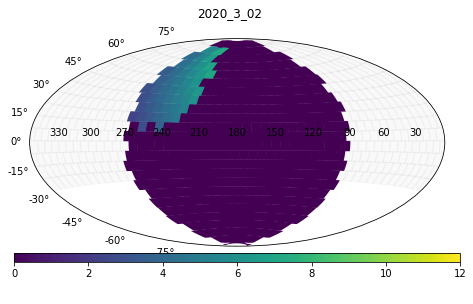

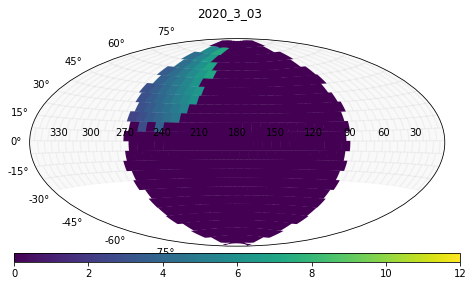

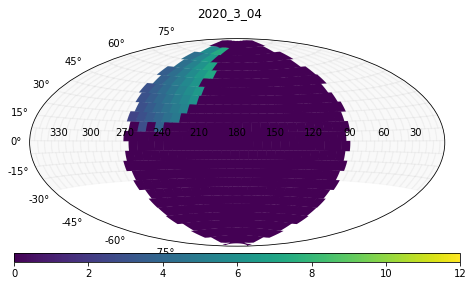

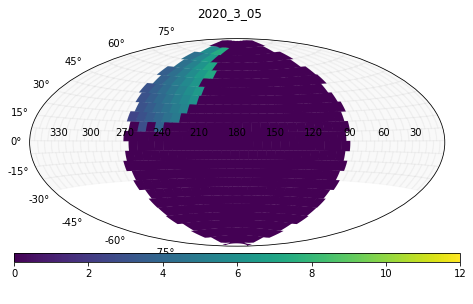

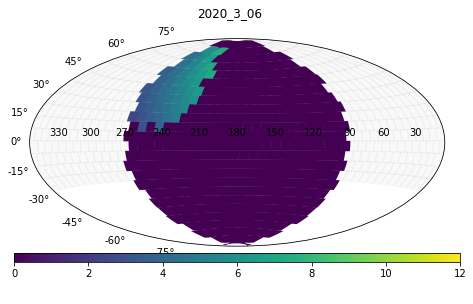

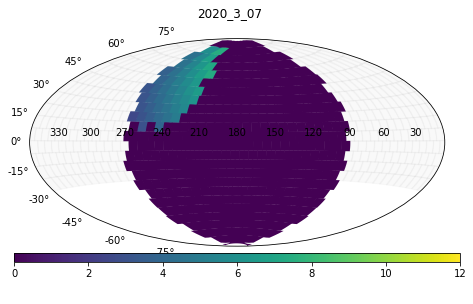

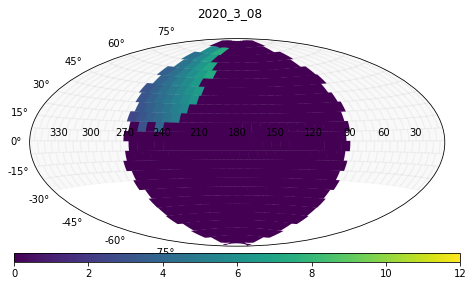

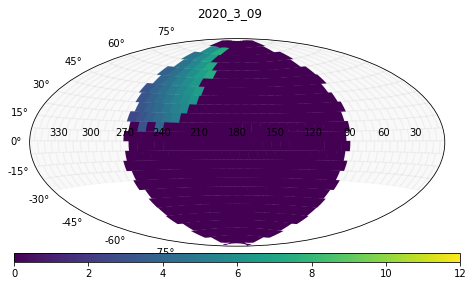

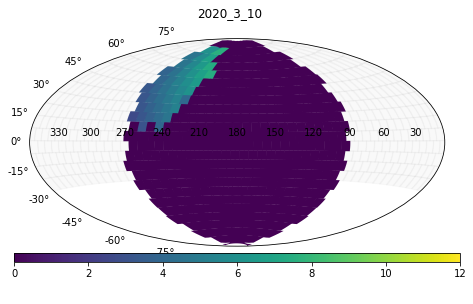

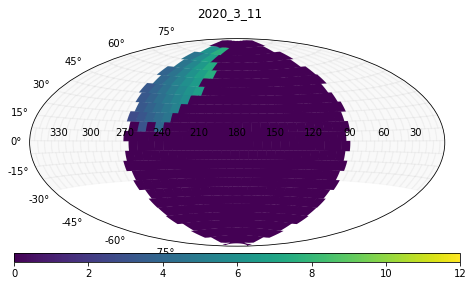

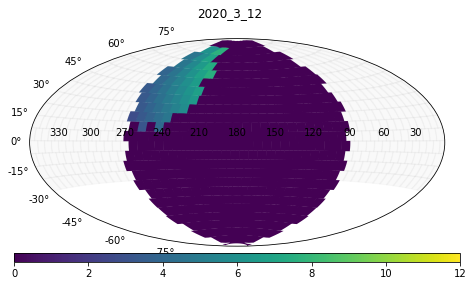

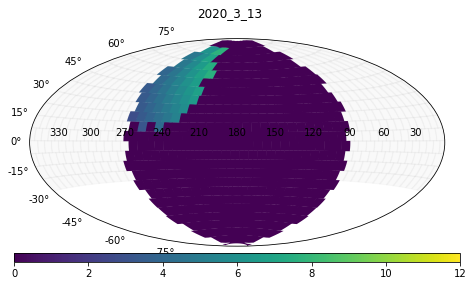

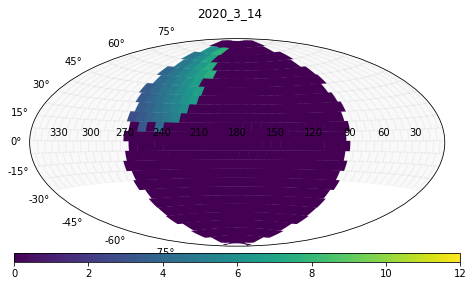

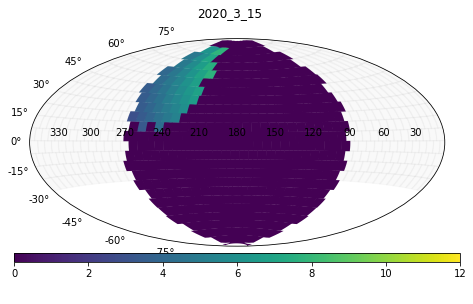

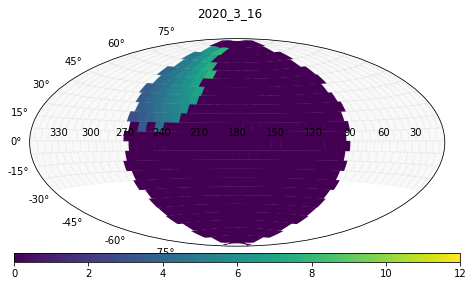

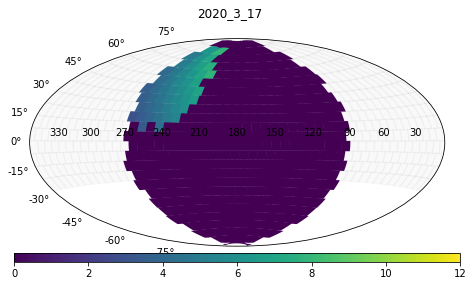

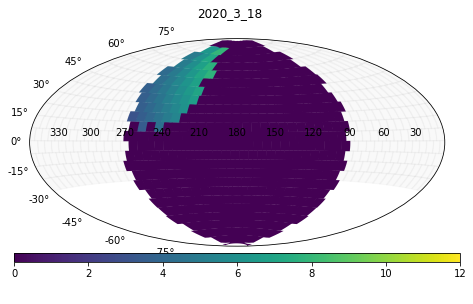

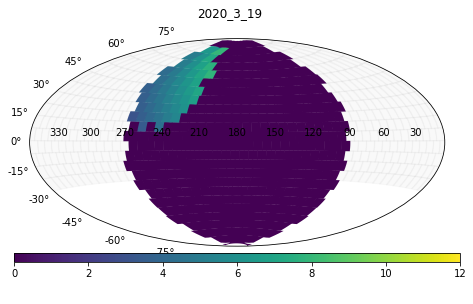

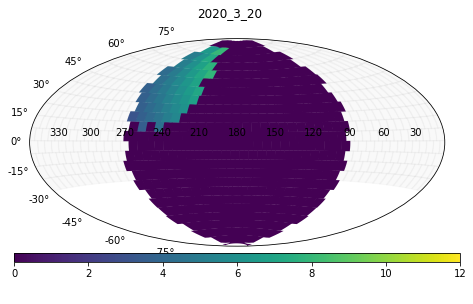

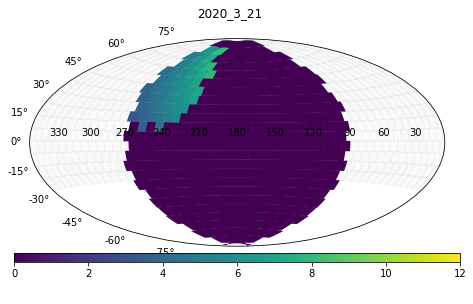

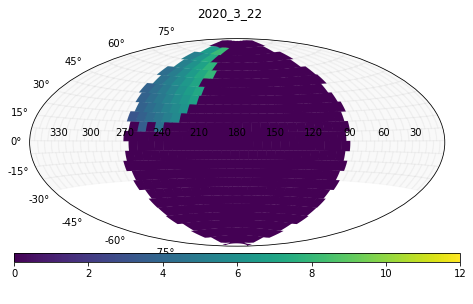

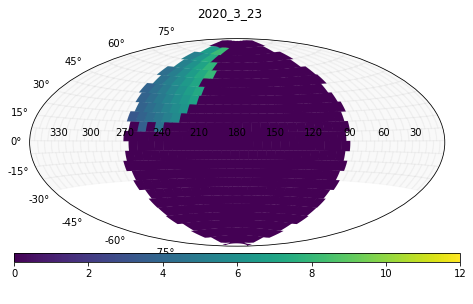

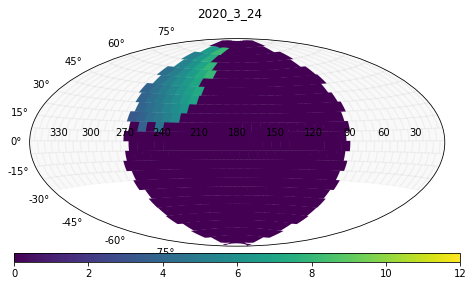

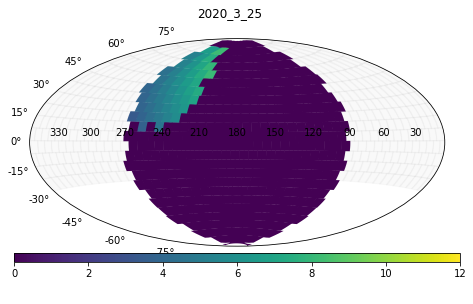

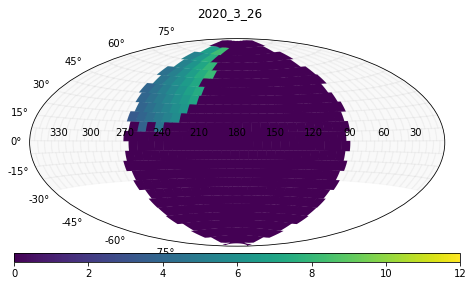

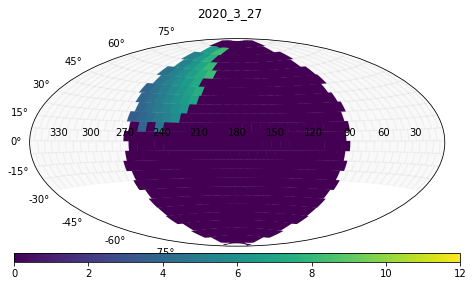

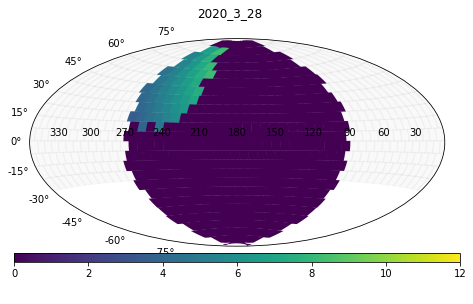

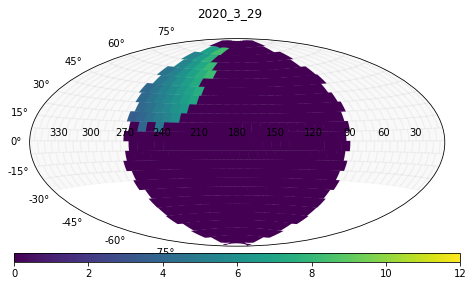

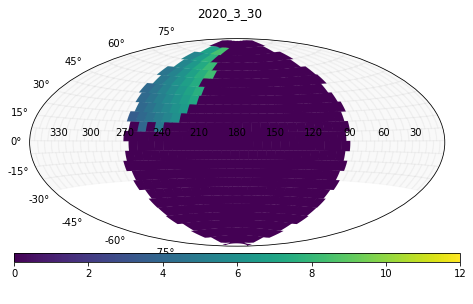

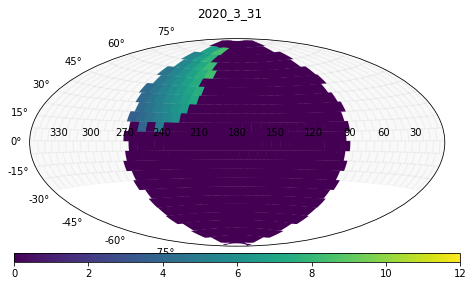

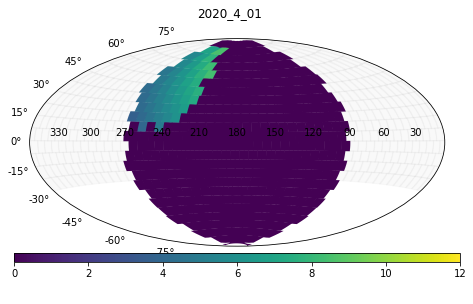

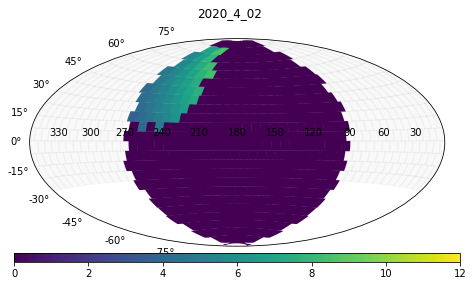

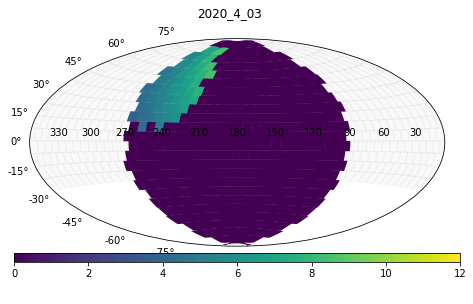

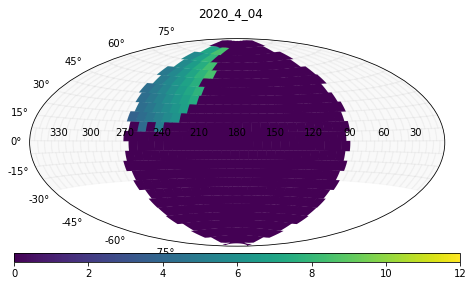

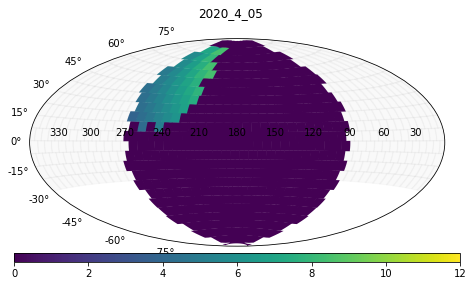

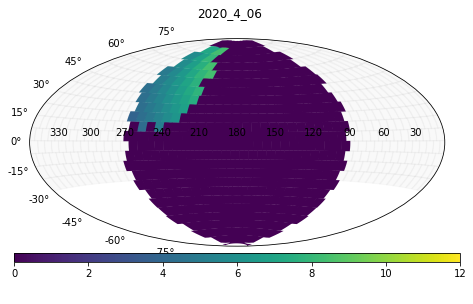

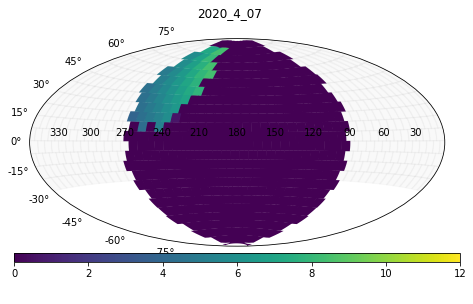

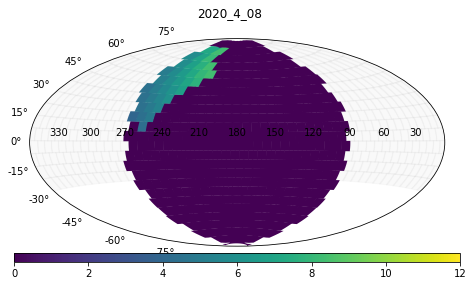

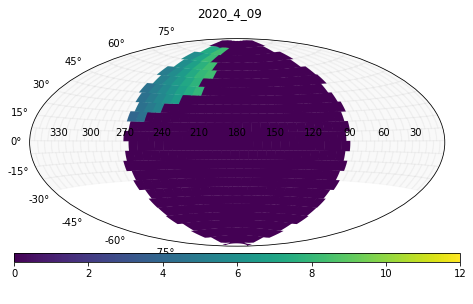

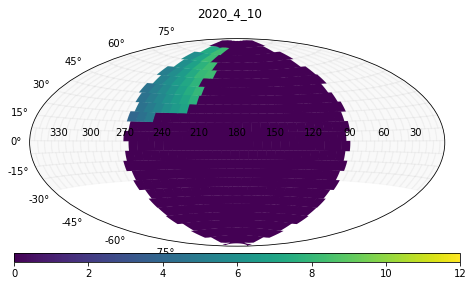

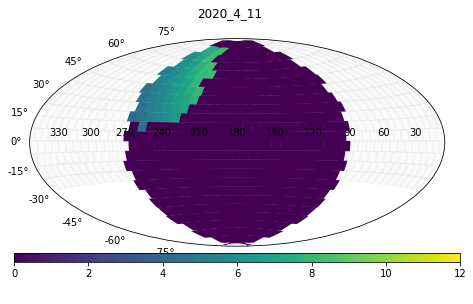

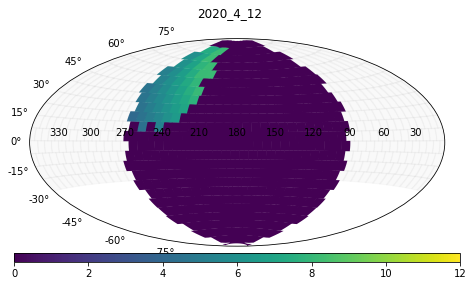

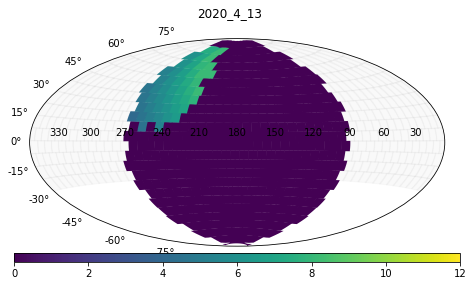

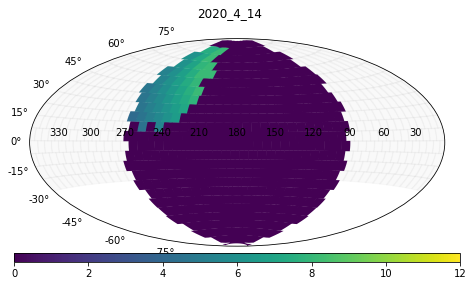

In [16]:
#mollweide projections for the field ID's 
aam_observe = np.loadtxt('AllObservability_JanApr.txt')
#paranal_aam_observe = np.loadtxt('Paranal_AllObservability_JanApr.txt')

times = time_grid_from_range(Time(["2020-01-01 00:00", "2020-04-15 00:00"]), time_resolution=1*u.day)
times_all = time_grid_from_range(Time(["2020-01-01 00:00", "2020-04-15 00:00"]), time_resolution=1*u.day)
twed_jd = times.jd
tall_jd = times_all.jd

#enumerate over the JD's of the time steps defined above
#make the plot for each day with a "mask" for the number of existing i-band observations
for i, wed_jd in enumerate(twed_jd):
    obs_dict = {}
    index_current = np.where(tall_jd == wed_jd)[0][0]
    index_next = index_current + 7 #because thats how weeks work 
    
    
    #iterate over the field IDs 
    for jj, fidval in enumerate(fid):
        #segment the observability
        fid_obs = aam_observe[int(fid[jj])-1]
        seg_fid_obs = fid_obs[index_current:index_next]        
        div_days = len(fid_obs[index_current:index_next])
        #print(div_days)
        avg_obs_hours = np.sum(seg_fid_obs)*24/div_days  #sum the nightly fraction, multiply by 24 and divide for weekly avg
        obs_iband = iband_numexp[:,1][iband_numexp[:,0] == int(fid[jj])]#odict_iband[str(int(fid[jj]))]
        if len(obs_iband) == 1:
            numObs_iband = obs_iband[0]
        else:
            numObs_iband = 0
        #print(fid[jj], numObs_iband)
        if numObs_iband >= 35:
            obs_dict[int(fid[jj])] = fid_obs[i]*24.#avg_obs_hours
        else:
            obs_dict[int(fid[jj])] = 0. #set to 0 if not enough i-band observations
            
    #if wed_jd == times[-1].jd:
    #    print(obs_dict)
    datetime_val = times[i].datetime
    if datetime_val.day < 10:
        day_str = '0'+str(datetime_val.day)
    elif datetime_val.day >= 10:
        day_str = str(datetime_val.day)
        
    fields.show_fields(obs_dict, vmin=0, vmax=12, title=str(datetime_val.year)+'_'+str(datetime_val.month)+'_'+day_str)
    plt.savefig("JanApr_ZUDS/NumObs35/Mollweide_NumHrsObs_"+str(datetime_val.year)+'_'+str(datetime_val.month)+'_'+day_str+".jpg")
    
    